In [1]:
import db_util
import gzip
import json
import math
import pandas as pd
import pymongo
import seaborn as sns
import scipy
import time

C:\Users\310195644\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
client = db_util.connect_mongo(host='localhost', username=None, password=None, port=27017, db='product')

# 0. Exploratory data analysis

## 0.1 Rating distribution

In [3]:
select_fields = ['overall']
cursor = client.item_review.find({'overall' : { '$exists': True },
                                  'itemPrice': {'$exists': True}},
                                 {'overall': 1, 'itemPrice': 1})
pd_rating = pd.DataFrame(list(cursor), columns=select_fields)
pd_rating_freq = pd_rating.groupby('overall').size().reset_index(name='count')
pd_rating['overall'].mean()

4.206829041301115

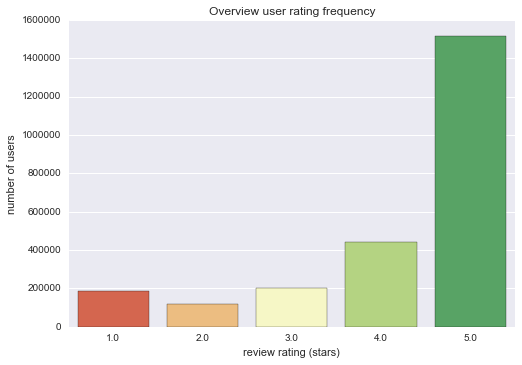

In [4]:
g = sns.barplot(x="overall", y="count", data=pd_rating_freq, palette=sns.color_palette("RdYlGn", 5))
g.set(xlabel='review rating (stars)', ylabel='number of users', title = 'Overview user rating frequency')
sns.plt.show()

In [5]:
del pd_rating_freq

## 0.2 Price distribution

In [ ]:
select_fields = ['asin', 'itemPrice']
cursor = client.item_review.find({'itemPrice': {'$exists': True} }, 
                                 {'asin': 1, 'itemPrice': 1})
pd_price = pd.DataFrame(list(cursor), columns=select_fields).drop_duplicates()
pd_price['itemPrice'].mean()

In [ ]:
g = sns.distplot(pd_price.itemPrice.dropna(), bins=100, kde=False, rug=False)
g.set_xticks(list(range(0, int(math.ceil(pd_price.itemPrice.max()))+1, 50)))
g.set_xlabel('product price ($)')
g.set_ylabel('number of products')
g.set_title('Product price distribution')
sns.plt.show()

In [ ]:
del pd_price

# 1. Is there a relation between price and reviews?

## 1.1 Price ~ rating

In [ ]:
select_fields = ['asin', 'avg_rating', 'itemPrice']
cursor = client.item_review.aggregate([ {'$match': {'itemPrice': {'$exists': True} } },
                                        {'$group': {'_id': '$asin',
                                                    'itemPrice': {'$avg': '$itemPrice'},
                                                    'avg_rating': {'$avg': "$overall"} } } ],
                                      allowDiskUse=True)
pd_rating = pd.DataFrame(list(cursor))
pd_rating.columns = select_fields

In [ ]:
scipy.stats.pearsonr(pd_rating.avg_rating, pd_rating.itemPrice)